In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df=pd.read_csv('../data/holdout_results.csv')

In [3]:
df

,score,label,cohort,pred
0,0.029353,0.0,TCGA,0
1,0.050943,0.0,TCGA,1
2,0.014300,0.0,TCGA,0
3,0.023140,0.0,TCGA,0
4,0.198863,0.0,TCGA,1
...,...,...,...,...
938,0.107994,0.0,PAN-Tumor Independent,1
939,0.066545,0.0,PAN-Tumor Independent,1
940,0.017529,0.0,PAN-Tumor Independent,0
941,0.621354,0.0,PAN-Tumor Independent,1


In [4]:
df=df[['cohort','label','score','pred']].reset_index(drop=True)
df.cohort.value_counts()

BLC3001                  420
PAN-Tumor Independent    361
BLC2002                   92
TCGA                      70
Name: cohort, dtype: int64

In [26]:
def auROC(quantile_df, cohort):
    
    fpr_qaunt, tpr_quant, thresholds_quant = roc_curve(y_true=quantile_df['label'], y_score=quantile_df['score'], drop_intermediate=False)
    auc_plot_quant = roc_auc_score(y_true=quantile_df['label'], y_score=quantile_df['score'])
    
    if cohort=='ALL':
        plt.plot(fpr_qaunt, tpr_quant, label='ROC', linewidth=2, linestyle='-')
    elif cohort == "PAN-Tumor Independent":
        plt.plot(fpr_qaunt, tpr_quant, label='ROC', linewidth=1.5, linestyle='-')
    else:
        plt.plot(fpr_qaunt, tpr_quant, label='ROC', linewidth=1.1, linestyle=':')
    
    plt.xlabel('FPR',fontsize=12)
    plt.ylabel('TPR',fontsize=12)
    print('Max AUC :', np.round(auc_plot_quant,4))
    plt.title('ROC curves per CRO Site')
    return auc_plot_quant

In [27]:
cohorts = ['BLC3001', 'BLC2002', 'TCGA', 'PAN-Tumor Independent']

Max AUC : 0.7961
Cohort name: BLC3001
Cohort count: 420
Max AUC : 0.7621
Cohort name: BLC2002
Cohort count: 92
Max AUC : 0.7835
Cohort name: TCGA
Cohort count: 70
Max AUC : 0.9819
Cohort name: PAN-Tumor Independent
Cohort count: 361
Max AUC : 0.7481


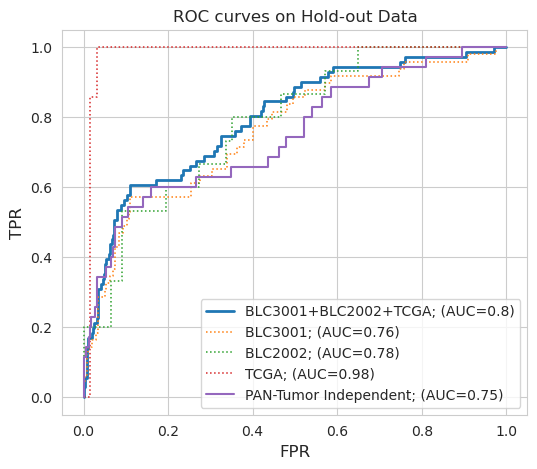

In [28]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(6,5))
auc_list = []
auc_list.append(auROC(df[df.cohort!='PAN-Tumor Independent'].reset_index(drop=True), cohort='ALL'))
cohort_count = []

for itx, group in enumerate(cohorts):

    print("Cohort name: " + str(group))
    tmp = df[(df['cohort'] == group)].reset_index(drop=True)
    
    cohort_count.append(tmp.shape[0])
    print("Cohort count: " + str(cohort_count[itx]))
    auc_list.append(auROC(tmp,cohort=group))
    
plt.legend(['BLC3001+BLC2002+TCGA; (AUC=' + str(round(auc_list[0],2)) + ')' ,
            'BLC3001; (AUC=' + str(round(auc_list[1],2)) + ')' ,
            'BLC2002; (AUC=' + str(round(auc_list[2],2)) + ')' ,
            'TCGA; (AUC=' + str(round(auc_list[3],2)) + ')' ,
            'PAN-Tumor Independent; (AUC=' + str(round(auc_list[4],2)) + ')'], loc=4, prop={'size': 10})

plt.title('ROC curves on Hold-out Data')
fig.savefig('../figures/Fig2.png')

In [29]:
def calculate_statistics(meta):
        
    sn = meta[(meta.pred==1) & (meta.label==1)].shape[0]/meta[meta.label==1].shape[0]
    sp = meta[(meta.pred==0) & (meta.label==0)].shape[0]/meta[meta.label==0].shape[0]
    
    TP = meta[(meta.pred==1) & (meta.label==1)].shape[0]
    TN = meta[(meta.pred==0) & (meta.label==0)].shape[0]
    FP = meta[(meta.pred==1) & (meta.label==0)].shape[0]
    FN = meta[(meta.pred==0) & (meta.label==1)].shape[0]
    
    SE_sn = np.sqrt((sn*(1-sn)/(TP+FN)))
    SE_sp = np.sqrt((sp*(1-sp)/(FP+TN)))

    CI_95_h = sn + 1.96*SE_sn
    CI_95_l = sn - 1.96*SE_sn

    print('Sensitivitiy: ' + str(round(sn,3)) + '; 95%CI=[' + str(round(CI_95_h,3)) + ', ' + str(round(CI_95_l,3)) + ']')
    
    CI_95_h = sp + 1.96*SE_sp
    CI_95_l = sp - 1.96*SE_sp

    print('Specificity: ' + str(round(sp,3)) + '; 95%CI=[' + str(round(CI_95_h,3)) + ', ' + str(round(CI_95_l,3)) + ']')
    
    red = meta[meta.pred==0].shape[0]/meta.shape[0]*100

    print('Reduction: ' + str(round(red)) + '% - Spec: ' + str(round(sp*100)) + '% - Sens: ' + str(round(sn*100)) + '%')

In [30]:
calculate_statistics(df)

Sensitivitiy: 0.943; 95%CI=[0.987, 0.899]
Specificity: 0.335; 95%CI=[0.366, 0.303]
Reduction: 30% - Spec: 33% - Sens: 94%


In [31]:
calculate_statistics(df[df.cohort=='BLC3001'].reset_index(drop=True))

Sensitivitiy: 0.918; 95%CI=[0.995, 0.842]
Specificity: 0.377; 95%CI=[0.427, 0.328]
Reduction: 34% - Spec: 38% - Sens: 92%


In [32]:
calculate_statistics(df[df.cohort=='TCGA'].reset_index(drop=True))

Sensitivitiy: 1.0; 95%CI=[1.0, 1.0]
Specificity: 0.476; 95%CI=[0.6, 0.353]
Reduction: 43% - Spec: 48% - Sens: 100%


In [33]:
calculate_statistics(df[df.cohort=='BLC2002'].reset_index(drop=True))

Sensitivitiy: 1.0; 95%CI=[1.0, 1.0]
Specificity: 0.286; 95%CI=[0.387, 0.185]
Reduction: 24% - Spec: 29% - Sens: 100%
